In [1]:
import numpy as np
import pandas as pd
import collections
from typing import List, Tuple


In [2]:
import os
os.chdir("D:/my_py_packages/supplyseer")

In [3]:
from src.supplyseer.experimental.experimentation.boundaries import gamma_exponential_log_mixture, gamma_exponential_mixture_bound, gamma_poisson_log_mixture, gamma_poisson_mixture_bound

In [4]:
def form_predictions(outcomes, selector, default_prediction):
    means = np.cumsum(outcomes * selector) / np.maximum(1, np.cumsum(selector))
    lagged_means = np.roll(means, 1)
    lagged_means[0] = default_prediction
    return lagged_means

In [5]:
def estimate_average_treatment_effect(outcomes, treatments, propensity,
                                      support_bounds, expected_outcome_noise,
                                      optimized_t, y1_predictions=None,
                                      y0_predictions=None, coverage_alpha=0.05,
                                      alpha_opt=0.05):
    support_center = (support_bounds[0] + support_bounds[1]) / 2.0
    v_opt = (optimized_t * expected_outcome_noise
             * (1 / propensity + 1 / (1 - propensity)))
    if y1_predictions is None:
        y1_predictions = form_predictions(outcomes, treatments == 1,
                                          support_center)
    if y0_predictions is None:
        y0_predictions = form_predictions(outcomes, treatments == 0,
                                          support_center)

    tau_hat = y1_predictions - y0_predictions
    weights = (treatments - propensity) / (propensity * (1 - propensity))
    predictions = np.where(treatments == 1, y1_predictions, y0_predictions)
    Xt = tau_hat + weights * (outcomes - predictions)
    St = np.cumsum(Xt)
    Vt = np.cumsum((Xt - tau_hat)**2)
    p_min = min(propensity, 1 - propensity)
    support_diameter = support_bounds[1] - support_bounds[0]
    c = 2 * support_diameter / p_min
    t_array = np.arange(1.0, len(outcomes) + 1.0)
    p_value = np.exp(-gamma_poisson_log_mixture(
             St, Vt, v_opt, c, alpha_opt=alpha_opt / 2))
    confidence_radius = (
        1.0 / t_array * gamma_poisson_mixture_bound(
            Vt, coverage_alpha / 2, v_opt, c, alpha_opt=alpha_opt / 2))
    return pd.DataFrame(collections.OrderedDict([
        ('t', t_array),
        ('point_estimate', St / t_array),
        ('upper_confidence_bound', np.minimum(
            support_diameter, St / t_array + confidence_radius)),
        ('lower_confidence_bound', np.maximum(
            -support_diameter, St / t_array - confidence_radius)),
        ('p_value', np.minimum(p_value, 1.0))]))

In [62]:
def check_approx_equal(name, actual, expected, tolerance=1e-4):
    abs_errors = np.abs(expected - actual)
    any_error = (abs_errors.max() > tolerance)
    if any_error:
        error_indexes = (abs_errors > tolerance).to_numpy().nonzero()[0]
        error_data = pd.DataFrame({
            'index': error_indexes,
            'expected': expected[error_indexes],
            'actual': actual[error_indexes]})
        print('Errors in {}'.format(name))
        print(error_data)
    return any_error

det = np.random.poisson(50, size=1000)
det_sum = det / sum(det)

def test_ate():
    data = pd.read_csv('ate_data.csv')
    results = estimate_average_treatment_effect(
        data["y"], data['treatment'], 0.5, [0, 1], 0.2 * 0.8, 50)
    return results
    # error_indicators = [
    #     check_approx_equal('upper confidence bounds',
    #                        results['upper_confidence_bound'],
    #                        data['upper_confidence_bound']),
    #     check_approx_equal('lower confidence bounds',
    #                        results['lower_confidence_bound'],
    #                        data['lower_confidence_bound']),
    #     check_approx_equal('point estimates',
    #                        results['point_estimate'],
    #                        data['point_estimate']),
    #     check_approx_equal('p-values', results['p_value'], data['p_value'])]
    
    if not any(error_indicators):
        print('Results match expectations')
        return results

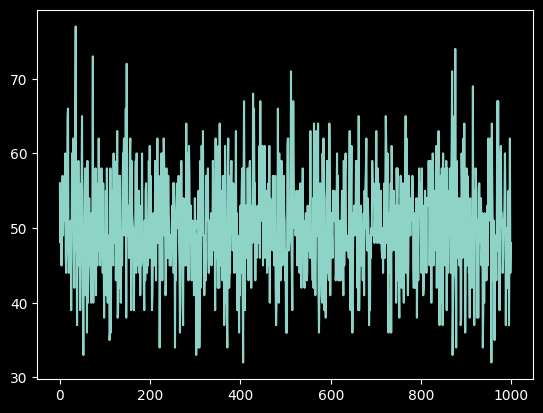

In [63]:
plt.plot(np.random.poisson(50, size=1000))

In [64]:
results = test_ate()

In [65]:
import matplotlib.pyplot as plt

In [59]:
results

,t,point_estimate,upper_confidence_bound,lower_confidence_bound,p_value
0,1.0,1.000000,1.000000,-1.000000,0.872915
1,2.0,1.000000,1.000000,-1.000000,0.728403
2,3.0,1.000000,1.000000,-1.000000,0.598988
3,4.0,0.500000,1.000000,-1.000000,0.839947
4,5.0,0.666667,1.000000,-1.000000,0.675082
...,...,...,...,...,...
995,996.0,0.172110,0.269875,0.074345,0.000003
996,997.0,0.172524,0.270201,0.074847,0.000002
997,998.0,0.172937,0.270526,0.075347,0.000002
998,999.0,0.173348,0.270850,0.075846,0.000002


In [60]:
np.argwhere(results["p_value"] < 0.05)[0]

array([357], dtype=int64)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Text(0.5, 1.0, 'P-values')

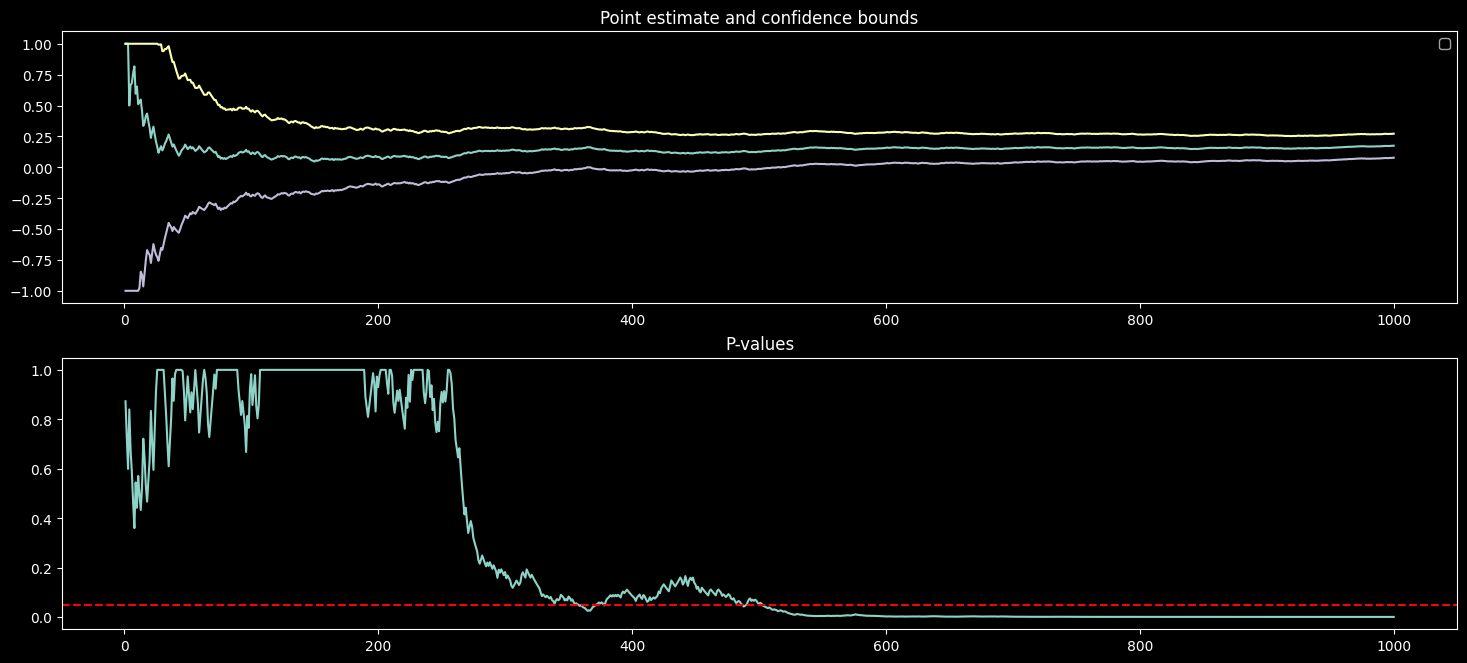

In [61]:
plt.style.use("dark_background")

plt.figure(figsize=(18, 12))
plt.subplot(3, 1, 1)
plt.plot(results["t"], results["point_estimate"])
plt.plot(results["t"], results["upper_confidence_bound"])
plt.plot(results["t"], results["lower_confidence_bound"])
# plt.axvline(np.argwhere(results["p_value"] < 0.05)[0], color="r", linestyle="--", label="alpha < 0.05")
plt.title("Point estimate and confidence bounds")
plt.legend()

plt.subplot(3, 1, 2)
plt.plot(results["t"], results["p_value"])
plt.axhline(0.05, color="r", linestyle="--")
# plt.axvline(np.argwhere(results["p_value"] < 0.05)[0], color="r", linestyle="--")
plt.title("P-values")


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Text(0.5, 1.0, 'P-values')

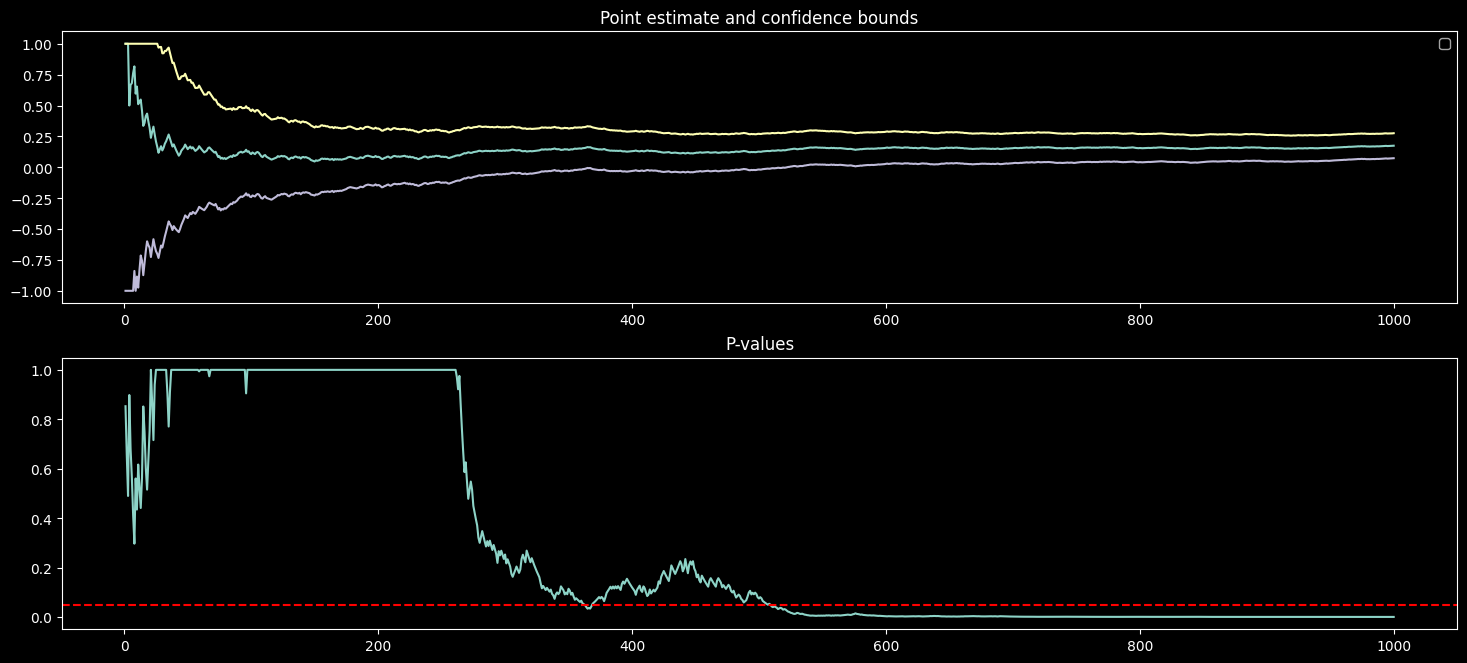

In [66]:
plt.style.use("dark_background")

plt.figure(figsize=(18, 12))
plt.subplot(3, 1, 1)
plt.plot(results["t"], results["point_estimate"])
plt.plot(results["t"], results["upper_confidence_bound"])
plt.plot(results["t"], results["lower_confidence_bound"])
# plt.axvline(np.argwhere(results["p_value"] < 0.05)[0], color="r", linestyle="--", label="alpha < 0.05")
plt.title("Point estimate and confidence bounds")
plt.legend()

plt.subplot(3, 1, 2)
plt.plot(results["t"], results["p_value"])
plt.axhline(0.05, color="r", linestyle="--")
# plt.axvline(np.argwhere(results["p_value"] < 0.05)[0], color="r", linestyle="--")
plt.title("P-values")
